## Part 1
- Overview
- Demo
- Model overview
- Preloaded model & tokenizer
- Quick test

## Part 2
- Update model
- Load dataset
- Data formatting loader

## Part 3
- Training
- Testing
- Recreate demo

# Download Modules

In [1]:
!pip install transformers sentencepiece datasets

     |████████████████████████████████| 3.1 MB 5.1 MB/s 
     |████████████████████████████████| 1.2 MB 34.4 MB/s 
     |████████████████████████████████| 290 kB 63.3 MB/s 
     |████████████████████████████████| 596 kB 49.9 MB/s 
     |████████████████████████████████| 59 kB 6.3 MB/s 
     |████████████████████████████████| 895 kB 47.2 MB/s 
     |████████████████████████████████| 3.3 MB 42.3 MB/s 
     |████████████████████████████████| 132 kB 61.5 MB/s 
     |████████████████████████████████| 1.1 MB 54.1 MB/s 
     |████████████████████████████████| 243 kB 53.1 MB/s 
     |████████████████████████████████| 192 kB 54.8 MB/s 
     |████████████████████████████████| 160 kB 53.9 MB/s 
     |████████████████████████████████| 271 kB 51.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from datasets import load_dataset
from google.colab import drive
from IPython.display import display
from IPython.html import widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook

sns.set()

/usr/local/lib/python3.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Use 'google/mt5-small' for non-pro cloab users
model_repo = 'google/mt5-base'
model_path = '/content/gdrive/My Drive/mt5_translation.pt'
max_seq_len = 20

# Load Tokenizer & Model

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_repo)

Downloading:   0%|          | 0.00/376 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/702 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

In [6]:
# Model description: https://huggingface.co/google/mt5-base
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)
model = model.cuda()

Downloading:   0%|          | 0.00/2.17G [00:00<?, ?B/s]

# Overview and Quick Test

In [9]:
token_ids = tokenizer.encode(
    '<jp> This will be translated to Japanese! (hopefully)',
    return_tensors='pt').cuda()
print(token_ids)

model_out = model.generate(token_ids)
print(model_out)

output_text = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(model_out[0]))
print(output_text)

tensor([[  1042,   3889,    669,   1494,    898,    390,  37194,    285,    288,
          30865,    309,    274, 116024,  11994,    271,      1]],
       device='cuda:0')
tensor([[     0, 250099,    259,    264,    259, 228700,      1]],
       device='cuda:0')
<pad> <extra_id_0> - issuu</s>


# Steps
1. Load the pretrained model and tokenizer
2. Load dataset
3. Transform dataset into input (entails a minor model change)
4. Train/finetune the model on our dataset
5. Test the model

# Test Tokenizer

In [10]:
example_input_str = '<jp> This is just a test nbuig.'
# example_input_str = 'これは普通のテスト'
input_ids = tokenizer.encode(example_input_str, return_tensors='pt')
print('Input IDs:', input_ids)

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print('Tokens:', tokens)

Input IDs: tensor([[1042, 3889,  669, 1494,  339, 1627,  259,  262, 2978,  259,  272, 1982,
         1315,  260,    1]])
Tokens: ['▁<', 'jp', '>', '▁This', '▁is', '▁just', '▁', 'a', '▁test', '▁', 'n', 'bu', 'ig', '.', '</s>']


In [11]:
sorted(tokenizer.vocab.items(), key=lambda x: x[1])

[('<pad>', 0),
 ('</s>', 1),
 ('<unk>', 2),
 ('<0x00>', 3),
 ('<0x01>', 4),
 ('<0x02>', 5),
 ('<0x03>', 6),
 ('<0x04>', 7),
 ('<0x05>', 8),
 ('<0x06>', 9),
 ('<0x07>', 10),
 ('<0x08>', 11),
 ('<0x09>', 12),
 ('<0x0A>', 13),
 ('<0x0B>', 14),
 ('<0x0C>', 15),
 ('<0x0D>', 16),
 ('<0x0E>', 17),
 ('<0x0F>', 18),
 ('<0x10>', 19),
 ('<0x11>', 20),
 ('<0x12>', 21),
 ('<0x13>', 22),
 ('<0x14>', 23),
 ('<0x15>', 24),
 ('<0x16>', 25),
 ('<0x17>', 26),
 ('<0x18>', 27),
 ('<0x19>', 28),
 ('<0x1A>', 29),
 ('<0x1B>', 30),
 ('<0x1C>', 31),
 ('<0x1D>', 32),
 ('<0x1E>', 33),
 ('<0x1F>', 34),
 ('<0x20>', 35),
 ('<0x21>', 36),
 ('<0x22>', 37),
 ('<0x23>', 38),
 ('<0x24>', 39),
 ('<0x25>', 40),
 ('<0x26>', 41),
 ('<0x27>', 42),
 ('<0x28>', 43),
 ('<0x29>', 44),
 ('<0x2A>', 45),
 ('<0x2B>', 46),
 ('<0x2C>', 47),
 ('<0x2D>', 48),
 ('<0x2E>', 49),
 ('<0x2F>', 50),
 ('<0x30>', 51),
 ('<0x31>', 52),
 ('<0x32>', 53),
 ('<0x33>', 54),
 ('<0x34>', 55),
 ('<0x35>', 56),
 ('<0x36>', 57),
 ('<0x37>', 58),
 ('<0x38>',

# Prepare Dataset

In [12]:
# Source: https://huggingface.co/datasets/alt
dataset = load_dataset('alt')

Downloading:   0%|          | 0.00/3.45k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.52k [00:00<?, ?B/s]

No config specified, defaulting to: alt/alt-parallel


Downloading:   0%|          | 0.00/21.1M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/162k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.23k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset alt downloaded and prepared to /root/.cache/huggingface/datasets/alt/alt-parallel/1.0.0/e784a3f2a9f6bdf277940de6cc9d700eab852896cd94aad4233caf26008da9ed. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
train_dataset = dataset['train']
test_dataset = dataset['test']

In [14]:
train_dataset[0]

{'SNT.URLID': '80188',
 'SNT.URLID.SNTID': '1',
 'translation': {'bg': 'ফ্রান্সের প্যারিসের পার্ক দি প্রিন্সেস-এ হওয়া ২০০৭-এর রাগবি বিশ্বকাপের পুল সি-তে ইটালি পর্তুগালকে ৩১-৫ গোলে হারিয়েছে।',
  'en': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes, Paris, France.',
  'en_tok': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes , Paris , France .',
  'fil': 'Natalo ng Italya ang Portugal sa puntos na 31-5 sa Grupong C noong 2007 sa Pandaigdigang laro ng Ragbi sa Parc des Princes, Paris, France.',
  'hi': '2007 में फ़्रांस, पेरिस के पार्क डेस प्रिंसेस में हुए रग्बी विश्व कप के पूल C में इटली ने पुर्तगाल को 31-5 से हराया।',
  'id': 'Italia berhasil mengalahkan Portugal 31-5 di grup C dalam Piala Dunia Rugby 2007 di Parc des Princes, Paris, Perancis.',
  'ja': 'フランスのパリ、パルク・デ・プランスで行われた2007年ラグビーワールドカップのプールCで、イタリアは31対5でポルトガルを下した。',
  'khm': 'អ៊ីតាលីបានឈ្នះលើព័រទុយហ្គាល់ 31-5 ក្នុងប៉ូលCនៃពីធីប្រកួតពានរង្វាន់

In [15]:
LANG_TOKEN_MAPPING = {
    'en': '<en>',
    'ja': '<jp>',
    'zh': '<zh>'
}

In [16]:
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

Embedding(250103, 768)

In [17]:
token_ids = tokenizer.encode(
    example_input_str, return_tensors='pt', padding='max_length',
    truncation=True, max_length=max_seq_len)
print(token_ids)

tokens = tokenizer.convert_ids_to_tokens(token_ids[0])
print(tokens)

tensor([[250101,   1494,    339,   1627,    259,    262,   2978,    259,    272,
           1982,   1315,    260,      1,      0,      0,      0,      0,      0,
              0,      0]])
['<jp>', '▁This', '▁is', '▁just', '▁', 'a', '▁test', '▁', 'n', 'bu', 'ig', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [18]:
def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]

  # Tokenize and add special tokens
  input_ids = tokenizer.encode(
      text = target_lang_token + text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]
  
def encode_target_str(text, tokenizer, seq_len,
                      lang_token_map=LANG_TOKEN_MAPPING):
  token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)
  
  return token_ids[0]

def format_translation_data(translations, lang_token_map,
                            tokenizer, seq_len=128):
  # Choose a random 2 languages for in i/o
  langs = list(lang_token_map.keys())
  input_lang, target_lang = np.random.choice(langs, size=2, replace=False)

  # Get the translations for the batch
  input_text = translations[input_lang]
  target_text = translations[target_lang]

  if input_text is None or target_text is None:
    return None

  input_token_ids = encode_input_str(
      input_text, target_lang, tokenizer, seq_len, lang_token_map)
  
  target_token_ids = encode_target_str(
      target_text, tokenizer, seq_len, lang_token_map)

  return input_token_ids, target_token_ids

def transform_batch(batch, lang_token_map, tokenizer):
  inputs = []
  targets = []
  for translation_set in batch['translation']:
    formatted_data = format_translation_data(
        translation_set, lang_token_map, tokenizer, max_seq_len)
    
    if formatted_data is None:
      continue
    
    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))
    
  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids

def get_data_generator(dataset, lang_token_map, tokenizer, batch_size=32):
  dataset = dataset.shuffle()
  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield transform_batch(raw_batch, lang_token_map, tokenizer)

In [19]:
# Testing `data_transform`
in_ids, out_ids = format_translation_data(
    train_dataset[0]['translation'], LANG_TOKEN_MAPPING, tokenizer)

print(' '.join(tokenizer.convert_ids_to_tokens(in_ids)))
print(' '.join(tokenizer.convert_ids_to_tokens(out_ids)))

# Testing data generator
data_gen = get_data_generator(train_dataset, LANG_TOKEN_MAPPING, tokenizer, 8)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)

<en> ▁ フランス の パリ 、 パル ク ・ デ ・ プラン ス で 行われた 2007 年 ラグビー ワールド カップ の プール C で 、 イタリア は 31 対 5 で ポル ト ガル を下 した 。 </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
▁Italy ▁have ▁de feat ed ▁Portugal ▁3 1-5 ▁in ▁Pool ▁C ▁of ▁the ▁2007 ▁ Rugby ▁World ▁Cup ▁at ▁Parc ▁des ▁Princes , ▁Paris , ▁France . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pa

# Train/Finetune BERT

In [20]:
model.load_state_dict(torch.load(model_path))

FileNotFoundError: ignored

In [21]:
# Constants
n_epochs = 8
batch_size = 16
print_freq = 50
checkpoint_freq = 1000
lr = 5e-4
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

In [22]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

In [23]:
losses = []

In [24]:
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [25]:
for epoch_idx in range(n_epochs):
  # Randomize data order
  data_generator = get_data_generator(train_dataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
                
  for batch_idx, (input_batch, label_batch) \
      in tqdm_notebook(enumerate(data_generator), total=n_batches):
    optimizer.zero_grad() #sets previous batch gradients to zero

    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)

    # Calculate loss and update weights
    loss = model_out.loss
    losses.append(loss.item())
    loss.backward() #backprop
    optimizer.step() #actually causes the movement of loss function towards minima (Gradient Descent Step)
    scheduler.step() #simply decays the lr

    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))
      
    if (batch_idx + 1) % checkpoint_freq == 0:
      test_loss = eval_model(model, test_dataset)
      print('Saving model with test loss of {:.3f}'.format(test_loss))
      torch.save(model.state_dict(), model_path)

torch.save(model.state_dict(), model_path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1131 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/alt/alt-parallel/1.0.0/e784a3f2a9f6bdf277940de6cc9d700eab852896cd94aad4233caf26008da9ed/cache-df1909c1c8427b76.arrow


Epoch: 1 | Step: 50 | Avg. loss: 9.897 | lr: 0.0002777777777777778
Epoch: 1 | Step: 100 | Avg. loss: 5.202 | lr: 0.0004994418396963608
Epoch: 1 | Step: 150 | Avg. loss: 3.969 | lr: 0.0004966510381781648
Epoch: 1 | Step: 200 | Avg. loss: 3.646 | lr: 0.0004938602366599688
Epoch: 1 | Step: 250 | Avg. loss: 3.447 | lr: 0.0004910694351417727
Epoch: 1 | Step: 300 | Avg. loss: 3.338 | lr: 0.0004882786336235767
Epoch: 1 | Step: 350 | Avg. loss: 3.176 | lr: 0.0004854878321053807
Epoch: 1 | Step: 400 | Avg. loss: 3.093 | lr: 0.00048269703058718467
Epoch: 1 | Step: 450 | Avg. loss: 3.146 | lr: 0.0004799062290689886
Epoch: 1 | Step: 500 | Avg. loss: 3.099 | lr: 0.00047711542755079264
Epoch: 1 | Step: 550 | Avg. loss: 3.066 | lr: 0.00047432462603259657
Epoch: 1 | Step: 600 | Avg. loss: 2.954 | lr: 0.00047153382451440055
Epoch: 1 | Step: 650 | Avg. loss: 2.887 | lr: 0.00046874302299620453
Epoch: 1 | Step: 700 | Avg. loss: 2.805 | lr: 0.00046595222147800846
Epoch: 1 | Step: 750 | Avg. loss: 2.758 | l

  0%|          | 0/1131 [00:00<?, ?it/s]

Epoch: 2 | Step: 50 | Avg. loss: 2.603 | lr: 0.0004391047108729627
Epoch: 2 | Step: 100 | Avg. loss: 2.635 | lr: 0.00043631390935476675
Epoch: 2 | Step: 150 | Avg. loss: 2.542 | lr: 0.0004335231078365707
Epoch: 2 | Step: 200 | Avg. loss: 2.599 | lr: 0.0004307323063183746
Epoch: 2 | Step: 250 | Avg. loss: 2.617 | lr: 0.00042794150480017864
Epoch: 2 | Step: 300 | Avg. loss: 2.458 | lr: 0.00042515070328198257
Epoch: 2 | Step: 350 | Avg. loss: 2.504 | lr: 0.00042235990176378655
Epoch: 2 | Step: 400 | Avg. loss: 2.530 | lr: 0.00041956910024559054
Epoch: 2 | Step: 450 | Avg. loss: 2.551 | lr: 0.0004167782987273945
Epoch: 2 | Step: 500 | Avg. loss: 2.463 | lr: 0.0004139874972091985
Epoch: 2 | Step: 550 | Avg. loss: 2.448 | lr: 0.0004111966956910025
Epoch: 2 | Step: 600 | Avg. loss: 2.449 | lr: 0.0004084058941728064
Epoch: 2 | Step: 650 | Avg. loss: 2.381 | lr: 0.00040561509265461045
Epoch: 2 | Step: 700 | Avg. loss: 2.502 | lr: 0.0004028242911364144
Epoch: 2 | Step: 750 | Avg. loss: 2.449 | l

ValueError: ignored

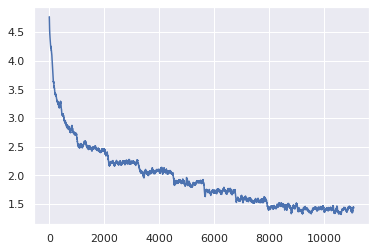

In [ ]:
# Graph the loss

window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

# Manual Testing

In [ ]:
test_sentence = test_dataset[0]['translation']['en']
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text = test_sentence,
    target_lang = 'ja',
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza.
Truncated input text: <jp> It has been confirmed that eight thoroughbred race horses at Randwick Racecourse</s>


In [ ]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3)
# print(output_tokens)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))

ランディウィック・レースコーストで8匹のトロピカル・レース・
ランディッキーのレース場で8匹のトロピカル・レース・ホッケーが
ランディック・レースコーストで8匹のトロピカル・レース・ホッ


In [ ]:
#@title Slick Blue Translate
input_text = 'A surfboarder ran into a shark' #@param {type:"string"}
output_language = 'ja' #@param ["en", "ja", "zh"]

input_ids = encode_input_str(
    text = input_text,
    target_lang = output_language,
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

output_tokens = model.generate(input_ids, num_beams=20, length_penalty=0.2)
print(input_text + '  ->  ' + \
      tokenizer.decode(output_tokens[0], skip_special_tokens=True))

A surfboarder ran into a shark  ->  水泳選手はサメの群れの中にいた。
